In [1]:
# !pip3 install torch torchvision

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets,transforms,models
from torch import nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
# import os 
# os.chdir('gdrive/My Drive/Colab Notebooks')
# !pwd

In [2]:
import importlib
import fc_loader
import helper

## Understanding shapes of given data

In [3]:
data_folder = '../data/flower_data/'

import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [4]:
transform = transforms.Compose([transforms.RandomRotation(30),
                                transforms.Resize((500,500)),
                                transforms.Resize((255,255)),
                               transforms.CenterCrop((224,224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                               transforms.Normalize((0.485, 0.456, 0.406),
                                                   (0.229, 0.224, 0.225))])
test_transform=transforms.Compose([transforms.Resize((500,500)),
                                transforms.Resize((255,255)),
                               transforms.CenterCrop((224,224)),
                                transforms.ToTensor(),
                                  transforms.Normalize((0.485, 0.456, 0.406),
                                                   (0.229, 0.224, 0.225))])

traindataset=datasets.ImageFolder(root=data_folder+'train/',transform=transform)
validdataset=datasets.ImageFolder(data_folder+'valid/',transform=test_transform)

trainloader=torch.utils.data.DataLoader(traindataset,batch_size=64,shuffle=True)
validloader=torch.utils.data.DataLoader(validdataset,batch_size=32)

In [5]:
labels_classes={labels:classes for classes,labels in 
                traindataset.class_to_idx.items()}
classes_labels = traindataset.class_to_idx

In [0]:
diter=iter(trainloader)
images,labels=next(diter)

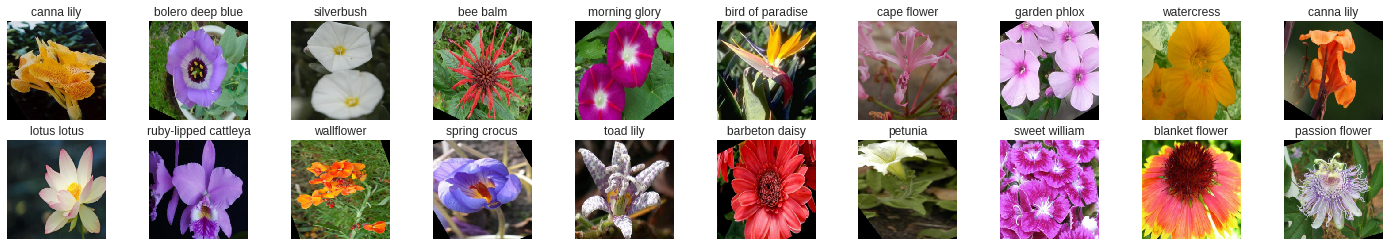

In [9]:
def imshow(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image.numpy().transpose((1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)

images,labels=next(iter(trainloader))
# images=images.numpy()

fig=plt.figure(figsize=(25,4))
for idx in range(20):
    ax=fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    imshow(images[idx])
    ax.set_title(cat_to_name[labels_classes[labels[idx].item()]]);

In [10]:
model = models.densenet121(pretrained=True)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:01<00:00, 22303889.49it/s]


In [0]:
print(model)

In [0]:
for param in model.parameters():
    param.requires_grad=False

In [0]:
from collections import OrderedDict

classifier=nn.Sequential(OrderedDict([
                          ('dropout1',nn.Dropout(0.1)),
                          ('fc1', nn.Linear(1024, 512)),
                          ('relu', nn.ReLU()),
                          ('dropout2',nn.Dropout(0.1)),
                          ('fc2', nn.Linear(512, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

In [0]:
model.classifier=classifier

In [0]:
criterion = nn.NLLLoss()
optimizer=torch.optim.Adam(model.classifier.parameters(),lr=0.001)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# Measure the validation loss and accuracy
def validation(model, dataloader, criterion, device):
    loss = 0
    accuracy = 0
    with torch.no_grad():
        for images, labels in iter(dataloader):
            
            images, labels = images.to(device), labels.to(device) # Move input and label tensors to the GPU
            
            output = model.forward(images)
            loss += criterion(output, labels).item()

            ps = torch.exp(output) # get the class probabilities from log-softmax
            equality = (labels.data == ps.max(dim=1)[1])
            accuracy += equality.type(torch.FloatTensor).mean()
    
    return loss, accuracy

In [7]:
# TODO: Save the checkpoint 
def savemodel():
    model.to('cpu')
    model.class_to_idx = classes_labels
    checkpoint = {'input_size': 224*224*3,
                  'output_size': 102,
                  'model': model,
                  'state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict,
                  'criterion': criterion,
                  'epochs': epochs,
                  'class_to_idx': model.class_to_idx}

    torch.save(checkpoint, 'final_model_flower.pth')
    model.to(device)

In [21]:
# Train the classifier layers using backpropagation using the pre-trained network to get the features
model.to(device)
epochs = 40
print_every = 40
steps = 0
running_loss = 0
train_accuracy = 0
valid_loss_min=np.Inf

for e in range(epochs):

    model.train() # Dropout is turned on for training

    for images, labels in iter(trainloader):

        images, labels = images.to(device), labels.to(device) # Move input and label tensors to the GPU

        steps += 1
        optimizer.zero_grad()
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # get the class probabilities from log-softmax
        ps = torch.exp(output) 
        equality = (labels.data == ps.max(dim=1)[1])
        train_accuracy += equality.type(torch.FloatTensor).mean()

        if steps % print_every == 0:

            model.eval() # Make sure network is in eval mode for inference

            with torch.no_grad():
                valid_loss, valid_accuracy = validation(model, validloader, criterion, device)

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Training Accuracy: {:.3f}".format(train_accuracy/print_every),
                  "Validation Loss: {:.3f}.. ".format(valid_loss/len(validloader)),
                  "Validation Accuracy: {:.3f}".format(valid_accuracy/len(validloader)))
            
            
            if valid_loss < valid_loss_min:
              savemodel()
              valid_loss_min=valid_loss

            running_loss = 0
            train_accuracy = 0
            model.train() # Make sure training is back on

print("\nTraining completed!")

Epoch: 1/40..  Training Loss: 2.248..  Training Accuracy: 0.523 Validation Loss: 1.509..  Validation Accuracy: 0.694
Epoch: 1/40..  Training Loss: 1.368..  Training Accuracy: 0.704 Validation Loss: 0.868..  Validation Accuracy: 0.850
Epoch: 2/40..  Training Loss: 0.866..  Training Accuracy: 0.804 Validation Loss: 0.659..  Validation Accuracy: 0.861
Epoch: 2/40..  Training Loss: 0.692..  Training Accuracy: 0.832 Validation Loss: 0.579..  Validation Accuracy: 0.867
Epoch: 2/40..  Training Loss: 0.594..  Training Accuracy: 0.868 Validation Loss: 0.481..  Validation Accuracy: 0.885
Epoch: 3/40..  Training Loss: 0.510..  Training Accuracy: 0.882 Validation Loss: 0.429..  Validation Accuracy: 0.896
Epoch: 3/40..  Training Loss: 0.415..  Training Accuracy: 0.896 Validation Loss: 0.396..  Validation Accuracy: 0.893
Epoch: 4/40..  Training Loss: 0.415..  Training Accuracy: 0.888 Validation Loss: 0.355..  Validation Accuracy: 0.902
Epoch: 4/40..  Training Loss: 0.354..  Training Accuracy: 0.912 

KeyboardInterrupt: ignored

In [8]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location='cpu')
    model = checkpoint["model"]
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [9]:
model = load_checkpoint('../models/final_model_flower.pth')

In [10]:
def process_image(pil_image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    # Resize the images where the shortest side is 256 pixels, keeping the aspect ratio
    width, height = pil_image.size
    aspect_ratio = width / height
    if aspect_ratio > 1:
        pil_image = pil_image.resize((round(aspect_ratio * 256), 256))
    else:
        pil_image = pil_image.resize((256, round(256 / aspect_ratio)))
    
    # Crop out the center 224x224 portion of the image
    width, height = pil_image.size
    new_width = 224
    new_height = 224
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    pil_image = pil_image.crop((round(left), round(top), round(right), round(bottom)))
    
    # Convert color channels to 0-1
    np_image = np.array(pil_image) / 255
    
    # Normalize the image
    np_image = (np_image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
    
    # Reorder dimensions
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

In [11]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [12]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    pil_image = Image.open(image_path)
    np_image = process_image(pil_image)

    model.to(device)
    model.eval()
    
    with torch.no_grad():
        images = torch.from_numpy(np_image)
        images = images.unsqueeze(0)
        images = images.type(torch.FloatTensor)
        images = images.to(device) # Move input tensors to the GPU/CPU

        output = model.forward(images)
        ps = torch.exp(output) # get the class probabilities from log-softmax

        probs, indices = torch.topk(ps, topk)
        probs = [float(prob) for prob in probs[0]]
        inv_map = {v: k for k, v in model.class_to_idx.items()}
        classes = [inv_map[int(index)] for index in indices[0]]
        
    return probs, classes

In [13]:
import matplotlib
from PIL import Image

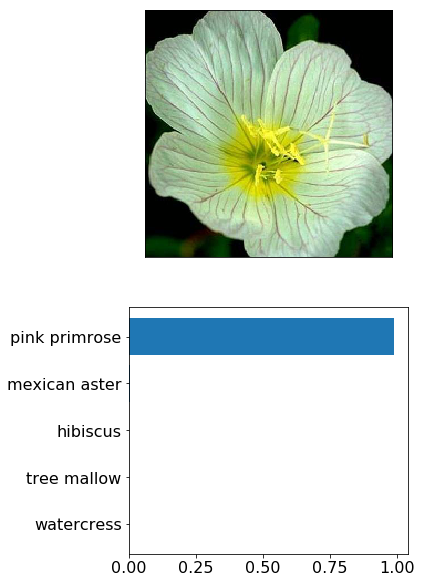

In [14]:
# TODO: Display an image along with the top 5 classes
test_dir = data_folder + "valid"
image_path = test_dir + "/1/image_06739.jpg"

f = plt.figure(figsize=(5,10))
matplotlib.rcParams.update({'font.size': 16})

ax = f.add_subplot(211)
pil_image = Image.open(test_dir + "/1/image_06739.jpg")
np_image = process_image(pil_image)
imshow(np_image, ax=ax)
ax.set_yticks([])
ax.set_xticks([])

plt.subplot(212)
probs, classes = predict(image_path, model, topk=5)
classes_name = [cat_to_name[class_i] for class_i in classes]
plt.barh(range(len((classes_name))), probs)
plt.yticks(range(len(classes_name)),classes_name)
plt.gca().invert_yaxis()